In [1]:
import  numpy as np
import matplotlib as plt


In [2]:
from qiskit import BasicAer, Aer,execute
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit


/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:107: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

In [3]:
import itertools 
from scipy.optimize import minimize
from scipy.linalg import expm,logm, sinm, cosm


In [4]:
from lib.math_sh import decompose,print_decompose
from lib.const import *
from lib.matchgate_02 import *
from lib.expected import expected

In [5]:
backend=Aer.get_backend('qasm_simulator')

In [6]:
# So in these situation we onlie have two qbit
# Initial state: S1=00 , S2=10,
# Initial Gate: G(\theta)

In [7]:
O_1=[[-1, 0, 0, 0],
     [0, 0.3, 0, 0],
     [0, 0, 0.3, 0],
     [0, 0, 0, 0.4]]
print_decompose(O_1)

IZ:(-0.35000000000000003+0j)
ZI:(-0.35+0j)
ZZ:(-0.3+0j)


In [8]:
class G_t():
    def __init__(self,t,q):
        #q-neighboring qubits q=(q_0,q_1) q_0<q_1
        #t-gate parameter
    
        self.t=t
        self.mat=np.array([[1,0,0,0],
                           [0,np.sin(self.t),np.cos(self.t),0],
                           [0,np.cos(self.t),-1*np.sin(self.t),0],
                           [0,0,0,-1]])
        self.qbits=q
        
    def gate(self):
        # create a gate from unitary self.mat 
        # this gate must be added to the circuit on q:
        #A=G_t(t)
        #qc.append(gate(A),[q_0,q_1])
        
        qc=QuantumCircuit(2,name='G_t('+str(t)+')')
        qc.unitary(self.mat,[0,1])
        return qc.to_gate()

In [9]:
'''
#Example:

t=np.pi/3
A=G_t(t,[1,2])
print("theta:",A.t)
print("q_0:{};q_1:{}".format(A.qbits[0],A.qbits[1]))
print("A matrix:\n",A.mat)
print_decompose(A.mat)

qr=QuantumRegister(7,'qr')
qc=QuantumCircuit(qr)
qc.append(A.gate(),[qr[A.qbits[0]],qr[A.qbits[1]]])
qc.draw('mpl')
'''

'\n#Example:\n\nt=np.pi/3\nA=G_t(t,[1,2])\nprint("theta:",A.t)\nprint("q_0:{};q_1:{}".format(A.qbits[0],A.qbits[1]))\nprint("A matrix:\n",A.mat)\nprint_decompose(A.mat)\n\nqr=QuantumRegister(7,\'qr\')\nqc=QuantumCircuit(qr)\nqc.append(A.gate(),[qr[A.qbits[0]],qr[A.qbits[1]]])\nqc.draw(\'mpl\')\n'

In [10]:
class init_xo():
    #class for initalial states of the form: 000, 100, 110, 111
    def __init__(self,nrq,x):
        #nrq-total number of qbits 
        #x-nr of qubits in state 1
        self.nrq=nrq
        self.x=x
        self.dens=self.densit(nrq,x)
        
    def densit(self,nrq,x):
        D=np.zeros((2**nrq,2**nrq))
        s=0
        for i in range (x):
            s=s+2**i
        D[s][s]=1
        return D

def circ_xo(xo,qc,qr):
    #xo-initial state
    #qc-quantum circuit with a regiter- 
    #qr-with at least nrq qbits
    for i in range(xo.x):
        qc.x(qr[i])

In [11]:
'''
# Example:

Init=init_xo(3,2)
print(Init.dens)

qr=QuantumRegister(7,'qr')
qc=QuantumCircuit(qr)
circ_xo(Init,qc,qr)
qc.draw('mpl')

'''

"\n# Example:\n\nInit=init_xo(3,2)\nprint(Init.dens)\n\nqr=QuantumRegister(7,'qr')\nqc=QuantumCircuit(qr)\ncirc_xo(Init,qc,qr)\nqc.draw('mpl')\n\n"

In [12]:
# Operators for Jordan-Wigner mapping
def get_c(nrq):
    x=[]
    for i in range (nrq):
        x2=X
        x21=Y
        for k in range(i):
            x2=np.kron(Z,x2)
            x21=np.kron(Z,x21)
        for k in range(i+1,nrq):
            x2=np.kron(x2,I)
            x21=np.kron(x21,I)
        x.append(x2)
        x.append(x21)
    return x

class c_op():
    def __init__(self,size):
        self.size=size
        self.elements=get_c(size)
        self.label,self.coef=self.labels()
        self.etichet=self.et()
    def et(self):
        et=[]
        for i in range(self.size*2):
            et.append('c_'+str(i))
        return et
    def labels(self):
        labels=[]
        coef=[]
        for j in self.elements:
            l=[]
            c=[]
            x_j,x_label=decompose(j)
            for i in range(len(x_j)):
                if(abs(x_j[i])!=0):
                    l.append(x_label[i])
                    c.append(x_j[i])
            labels.append(l)
            coef.append(c)
        return labels, coef
    def info(self):
        print('size:',self.size)
        label=self.label
        coef=self.coef
        print('nr. elements:',len(label))
        for i in range(len(label)):
            print(self.etichet[i])
            print('labels:',label[i])
            print('coef:',coef[i])
            print('matrix: \n',self.elements[i])
            print("#################################################")

In [13]:
'''
# Example:

C=c_op(2)
C.info()

'''

'\n# Example:\n\nC=c_op(2)\nC.info()\n\n'

In [14]:
class obs_2c():
    def __init__(self,a,C):
        self.a=a
        self.C=C
        self.mat="Not calculate yet use self.matrix() to fix the problem"
    
    def matrix(self):
        s=np.zeros((2**C.size,2**C.size))
        for i in range(len(a)):
            for j in range(len(a)):
                if (a[i][j]!=0):
                    s=s+a[i][j]*np.matmul(C.elements[i],C.elements[j])
        self.mat=1j/2*s

In [15]:
'''
a= np.array([[0,1,0,0],
             [-1,0,0,0],
             [0,0,0,0],
             [0,0,0,0] ])
C=c_op(2)

OBS=obs_2c(a,C)

OBS.matrix()
print(OBS.mat)

print_decompose(OBS.mat)

h,h_label=decompose(OBS.mat)
'''

'\na= np.array([[0,1,0,0],\n             [-1,0,0,0],\n             [0,0,0,0],\n             [0,0,0,0] ])\nC=c_op(2)\n\nOBS=obs_2c(a,C)\n\nOBS.matrix()\nprint(OBS.mat)\n\nprint_decompose(OBS.mat)\n\nh,h_label=decompose(OBS.mat)\n'

In [16]:
nrq=2
C=c_op(nrq)

#Initial state
Init=init_xo(2,0)

#Gate 
t=2*np.pi/3
A=G_t(t,[0,1])

#Observable
a= np.array([[0, 1, 0,  0],
             [-1,0, 0, 0],
             [0, 0, 0,  0],
             [0, 0, 0,  0] ])

OBS=obs_2c(a,C)
OBS.matrix()
h,h_label=decompose(OBS.mat)

print_decompose(OBS.mat)

ZI:(-1+0j)


/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/circuit/register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/circuit/register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np

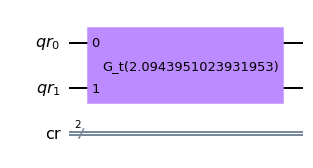

In [17]:
qr=QuantumRegister(nrq,'qr')
cr=ClassicalRegister(nrq,'cr')
qc=QuantumCircuit(qr,cr)

circ_xo(Init,qc,qr)
qc.append(A.gate(),[qr[A.qbits[0]],qr[A.qbits[1]]])

qc.draw('mpl')

In [18]:
val=0
for i in range(len(h)):
    if h[i]!=0:
        exp=expected(qc,h_label[i],shots=100000,backend=backend)
        val=val+h[i]*exp
        print('exp for {} ={}'.format(h_label[i],exp))
print("val:",val)

/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/circuit/register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/Users/voicutu/opt/anaconda3/envs/CQ/lib/python3.8/site-packages/qiskit/circuit/register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np

exp for ZI =1.0
val: (-1+0j)


In [19]:
#Compression

In [20]:
def comutation(mat1,mat2):
    return np.matmul(mat1,mat2)-np.matmul(mat2,mat1)


def corelation(dens,op):
    nrq=int(np.log2(len(dens)))
    x=op.elements
    #print(x)
    Co=[]
    for  i in range(2*nrq):
        li=[]
        for j in range(2*nrq):
            li.append(-1*(1.0j/2)*np.matmul(comutation(x[i],x[j]),dens).trace())
        Co.append(li)
    return Co

#Creat density matrix for the compress state  from initial density 
def new_state(dens,op):
    nrq=int(np.log2(len(dens)))
    ide=np.identity(2*nrq,dtype=np.complex128)
    Co=corelation(dens,op)
    for i in range(len(Co)):
        for j in range(len(Co)):
            Co[i][j]=1j*(Co[i][j])
    return (1/(2*nrq))*(ide+Co)



In [21]:
class R_gate:
    def __init__(self,gate,size):
        #gate=deasire G_t; size= total nr of qbits
        self.k_1=gate.qbits[0]
        self.k_2=gate.qbits[1]
        self.g_t=gate
        self.t=gate.t
        self.size=size
        self.mat="Not calculate yet. Solve these problem usig self.get_R_mat()"
        
    def get_R_h(self):
        a=self.t
        h=np.zeros((2*self.size,2*self.size))
        k_1=self.k_1
        k_2=self.k_2
        h[2*k_1+1][2*k_1]=(np.cos(a*2)+1)/4
        h[2*k_1][2*k_1+1]=-(np.cos(a*2)+1)/4
        h[2*k_2][2*k_1+1]=np.sin(a*2)/4
        h[2*k_1+1][2*k_2]=-np.sin(a*2)/4
        h[2*k_2+1][2*k_2]=(1-np.cos(a*2))/4
        h[2*k_2][2*k_2+1]=-(1-np.cos(a*2))/4
        h[2*k_2+1][2*k_1]=-np.sin(a*2)/4
        h[2*k_1][2*k_2+1]=np.sin(a*2)/4
           
        return h
        
    def get_R_mat(self):
        self.mat=-1j*expm(4*np.pi/2*self.get_R_h())
        
    def gate(self):
        # create a gate from unitary self.mat     
        qc=QuantumCircuit(2,name='R_t_t')
        qc.unitary(self.mat,[0,1])
        return qc.to_gate()

In [22]:
def dec_vec(nr,nrq):
    r=np.zeros(2**nrq) 
    r[nr]=1
    return r

#A=1j/2(\sum_0^(2n-1)a_{j,k}c_jc_k)
def compress_obs(obs):
    s=np.zeros((len(obs.C.elements),len(obs.C.elements)))
    for i in range(len(obs.a)):
        for j in range(len(obs.a)):
            s=s+a[i][j]*np.outer(dec_vec(i,obs.C.size),dec_vec(j,obs.C.size))
    return 1j/2*s

In [23]:
#Compress Initial state:

init_d=Init.dens

print("Initial density:")
for i in init_d:
    print(i)
    
new=new_state(init_d,C)
print("\n New density:")
for i in new:
    print(i)
    
print_decompose(new)

Initial density:
[1. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]

 New density:
[0.25+0.j   0.  +0.25j 0.  +0.j   0.  +0.j  ]
[0.  -0.25j 0.25+0.j   0.  +0.j   0.  +0.j  ]
[0.  +0.j   0.  +0.j   0.25+0.j   0.  +0.25j]
[0.  +0.j   0.  +0.j   0.  -0.25j 0.25+0.j  ]
II:(0.25+0j)
IY:(-0.25+0j)


In [24]:
#Compress Gate:
R=R_gate(A,2)
R.get_R_mat()
R.mat


array([[0.-5.00000000e-01j, 0.-4.11746600e-17j, 0.+8.66025404e-01j,
        0.-8.23493200e-17j],
       [0.-7.33517790e-17j, 0.-5.00000000e-01j, 0.+7.33517790e-17j,
        0.+8.66025404e-01j],
       [0.+8.66025404e-01j, 0.+0.00000000e+00j, 0.+5.00000000e-01j,
        0.-2.47470860e-17j],
       [0.-0.00000000e+00j, 0.+8.66025404e-01j, 0.-4.40864061e-17j,
        0.+5.00000000e-01j]])

In [25]:

R_=np.cos(np.pi/2)*np.identity(4)-2*np.sin(np.pi/2)*R.get_R_h()



qc=QuantumCircuit(2,name='R_t_t')
qc.unitary(R_,[0,1])
R_g=qc.to_gate()

ExtensionError: 'Input matrix is not unitary.'

In [ ]:
R_

In [ ]:
R.get_R_h()

In [ ]:
#Compres Observable
OBS_compress=compress_obs(OBS)
hc,hc_label=decompose(OBS_compress)

print("###")
print_decompose(OBS.mat)
print("###")
print(OBS_compress)
print_decompose(OBS_compress)

In [ ]:
print_decompose(OBS.mat)

In [ ]:
#Compress Circuit

nrq=2

qr_c=QuantumRegister(nrq,'qr_c')
cr_c=ClassicalRegister(nrq,'cr_c')
qc_c=QuantumCircuit(qr_c,cr_c)

#qc_c.z(qr_c[0])
qc_c.y(qr_c[1])
qc_c.rx(np.pi/2,qr_c[1])


#compress gates 
#qc_c.append(R_g,qr_c)


qc_c.draw('mpl')

In [ ]:
val=0
for i in range(len(hc)):
    if hc[i]!=0:
        exp=expected(qc_c,hc_label[i],shots=100000,backend=backend)
        val=val+hc[i]*exp
        print('exp for {} ={}'.format(hc_label[i],exp))
        print(hc[i])
val_1=2*val
print(val_1)

In [ ]:
qr=QuantumRegister(nrq,'qr')
cr=ClassicalRegister(nrq,'cr')
qc=QuantumCircuit(qr,cr)

circ_xo(Init,qc,qr)
qc.append(A.gate(),[qr[A.qbits[0]],qr[A.qbits[1]]])

val=0
for i in range(len(h)):
    if h[i]!=0:
        exp=expected(qc,h_label[i],shots=100000,backend=backend)
        val=val+h[i]*exp
        print('exp for {} ={}'.format(h_label[i],exp))
print("val:",val)